# Imports

In [31]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from joblib import Memory, dump, load


In [32]:
# data set returns an empty last column, so dropping it
df = pd.read_csv('https://github.com/YBIFoundation/Dataset/raw/main/Cancer.csv').drop(columns='Unnamed: 32', axis=1)

# EDA

In [33]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [34]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [35]:
df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## df info notes:
- Id column can be dropped
- diagnosis is type object, B fo benign M for Malignant; convert to binary
- there is no missing data
- target values are balanced

## change diagnosis column to binary

In [37]:
lb= LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'])



In [38]:
df['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

## drop id column

In [39]:
df = df.drop(columns=['id'])
df.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


## create X and y

In [40]:
X = df.drop(columns='diagnosis')
X.head(1)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


In [41]:
y = df['diagnosis']
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

## split data

In [42]:
rng = np.random.RandomState(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=rng)

## check multicolinearity

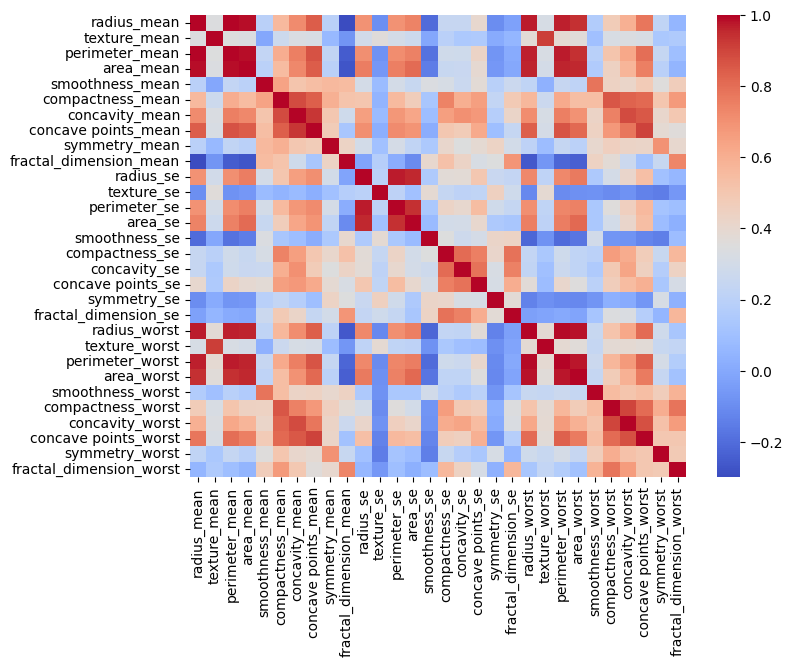

In [43]:
corr_matrix = X_train.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

no HUGE issues with multicolinearity. Will come back to this if model does not perform well or if we need to fine tune

In [44]:
corr_matrix

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.341638,0.998113,0.987475,0.196539,0.560255,0.720324,0.846078,0.194218,-0.299369,0.698322,-0.096314,0.696827,0.741313,-0.203611,0.246651,0.248112,0.402409,-0.097109,-0.027111,0.969651,0.315631,0.967603,0.940332,0.162581,0.473233,0.594784,0.778098,0.218750,0.055499
texture_mean,0.341638,1.000000,0.348328,0.336787,-0.009571,0.272357,0.331907,0.322841,0.070007,-0.071273,0.291904,0.363065,0.301873,0.272825,-0.007984,0.196464,0.146940,0.155758,0.006038,0.051169,0.378549,0.917048,0.387879,0.367760,0.101317,0.321862,0.339954,0.323560,0.139287,0.155761
perimeter_mean,0.998113,0.348328,1.000000,0.987013,0.229177,0.605370,0.754751,0.870511,0.225539,-0.253544,0.708743,-0.085650,0.713441,0.748736,-0.184554,0.288362,0.280902,0.431272,-0.072936,0.007260,0.968166,0.320931,0.971081,0.939478,0.187974,0.509826,0.626672,0.800015,0.240450,0.094817
area_mean,0.987475,0.336787,0.987013,1.000000,0.202672,0.551609,0.727528,0.844721,0.195812,-0.269391,0.757947,-0.065404,0.755462,0.810855,-0.150225,0.250287,0.256456,0.393766,-0.061225,-0.004522,0.962901,0.303010,0.961930,0.958250,0.161030,0.446278,0.574882,0.751439,0.194951,0.049395
smoothness_mean,0.196539,-0.009571,0.229177,0.202672,1.000000,0.642849,0.510374,0.541578,0.559688,0.553252,0.302951,0.080484,0.299949,0.253841,0.337414,0.318971,0.261634,0.379036,0.191063,0.266950,0.222772,0.035516,0.246033,0.217298,0.786347,0.440064,0.417400,0.477731,0.359278,0.462831
compactness_mean,0.560255,0.272357,0.605370,0.551609,0.642849,1.000000,0.886513,0.841651,0.595582,0.512899,0.506725,0.042403,0.557623,0.466228,0.128224,0.742792,0.603638,0.657240,0.229668,0.486784,0.566564,0.264497,0.618993,0.538999,0.541177,0.861746,0.828536,0.816734,0.503051,0.672858
concavity_mean,0.720324,0.331907,0.754751,0.727528,0.510374,0.886513,1.000000,0.929952,0.499257,0.282268,0.655241,0.075345,0.681786,0.633486,0.088214,0.659049,0.700909,0.679425,0.179955,0.423134,0.714830,0.314962,0.754254,0.699291,0.428998,0.750868,0.884739,0.856815,0.408270,0.494568
concave points_mean,0.846078,0.322841,0.870511,0.844721,0.541578,0.841651,0.929952,1.000000,0.473360,0.129168,0.705910,0.020414,0.718914,0.690810,0.019242,0.500299,0.473725,0.618322,0.093387,0.242058,0.840040,0.309522,0.864407,0.816576,0.440699,0.677871,0.777743,0.907434,0.387403,0.363701
symmetry_mean,0.194218,0.070007,0.225539,0.195812,0.559688,0.595582,0.499257,0.473360,1.000000,0.434855,0.297463,0.105034,0.306027,0.225358,0.146436,0.406892,0.346154,0.387270,0.433441,0.295926,0.211354,0.082362,0.241538,0.200739,0.402178,0.456678,0.427185,0.424628,0.699154,0.404172
fractal_dimension_mean,-0.299369,-0.071273,-0.253544,-0.269391,0.553252,0.512899,0.282268,0.129168,0.434855,1.000000,-0.017976,0.177755,0.016294,-0.102532,0.403033,0.525030,0.430977,0.321346,0.350173,0.687697,-0.263113,-0.068166,-0.218967,-0.239031,0.440045,0.377569,0.268605,0.111185,0.252307,0.734691


## mutual Info

This test will show how much information each feature shares with the target class (malignant)

In [45]:
X.shape

(569, 30)

In [46]:
mi = mutual_info_classif(X_train, y_train, random_state=rng)
print(X_test.columns, '\n',mi,'\n' )
mi_df = pd.DataFrame(index=X.columns, data=mi, columns=['feature_importance'])
mi_df.sort_values(by='feature_importance', ascending=False)

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object') 
 [0.38626086 0.10678054 0.42471301 0.38825427 0.08745973 0.23046714
 0.39868809 0.43962086 0.0499593  0.01043533 0.24533676 0.
 0.27324949 0.36200876 0.0069922  0.09052813 0.12398449 0.12006094
 0.00104205 0.05840223 0.4682543  0.12408373 0.49062494 0.48040878
 0.11852209 0.26612005 0.36090979 0.46894831 0.09404643 0.05916795] 



,feature_importance
perimeter_worst,0.490625
area_worst,0.480409
concave points_worst,0.468948
radius_worst,0.468254
concave points_mean,0.439621
perimeter_mean,0.424713
concavity_mean,0.398688
area_mean,0.388254
radius_mean,0.386261
area_se,0.362009


# Experiment 1

## model Training
This model fit section contains a *logistic regression* model and a *gradient boosting tree* at both default settings. Purpose:
- quick training
- get sense of model / predictions
- we will tune hyperparameters accordingly in experiment 2

In [47]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])
pipe_lr.fit(X_train, y_train)
pipe_gb.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gb', GradientBoostingClassifier())])

## predictions


In [48]:
y_pred_lr = pipe_lr.predict(X_test)
y_pred_gb = pipe_gb.predict(X_test)
print(f'Logistic Regression classification report:\n{classification_report(y_test, y_pred_lr)}')
print(f'Gradient Boosting classification report:\n{classification_report(y_test, y_pred_gb)}')

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Gradient Boosting classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



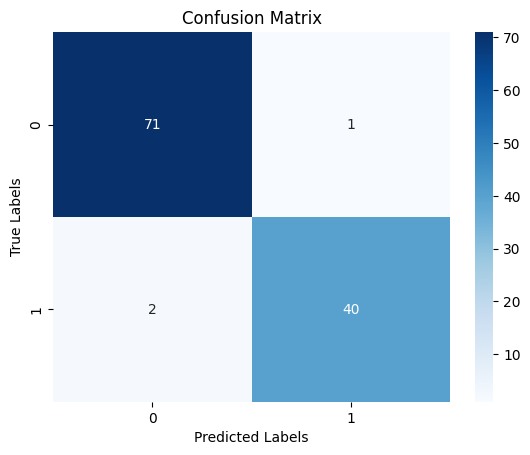

In [64]:
# log reg confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='d')  # fmt='d' for integers
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## conclusion
Accuracy, precision, recall, and f1 score all hae very high scores in the high 90s.
- Logisitic Regression scored higher than gradient boosting
- Data was given to us pretty clean, not a lot of preprocessing and hyperparameter tuning had to be done
- That being said, I will run a 2nd experiement with preprocessing and hyperparameter tuning to see if we can get any improvements

# Experiment 2

## multicolinearity

In [50]:
corr_matrix = X_train.corr().abs()
threshold = 0.8

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper.columns if any(upper[column] > threshold)]
print("Highly correlated features:", highly_correlated)
print(len(highly_correlated))

Highly correlated features: ['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'concavity_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']
14


## mutual info

In [51]:
mi = mutual_info_classif(X_train, y_train, random_state=rng)
mi_df = pd.DataFrame(index=X.columns, data=mi, columns=['mi_score'])
mi_df.sort_values(by='mi_score', ascending=False)

,mi_score
perimeter_worst,0.491125
area_worst,0.481141
radius_worst,0.470650
concave points_worst,0.466125
concave points_mean,0.439657
perimeter_mean,0.425366
concavity_mean,0.401544
radius_mean,0.390043
area_mean,0.385768
area_se,0.362458


In [52]:
pipe_lr.named_steps['lr'].coef_

array([[ 0.43458075,  0.42339927,  0.41846885,  0.44954044,  0.20224574,
        -0.3077925 ,  0.77896163,  0.83252059, -0.22123389, -0.26944793,
         1.11986755, -0.08984742,  0.6674272 ,  0.78999634,  0.20407062,
        -0.90465029,  0.10099375,  0.44770395, -0.13049216, -0.72220539,
         1.08907679,  1.0336632 ,  0.94263667,  0.99920696,  0.57070065,
        -0.02375468,  0.90367114,  0.88581516,  0.79540467,  0.50072126]])

In [53]:
pipe_gb.named_steps['gb'].feature_importances_
gb_feature_importances = pd.Series(pipe_gb.named_steps['gb'].feature_importances_.round(6), index=X_test.columns)
gb_feature_importances.sort_values(ascending=False)

perimeter_worst            0.398953
area_worst                 0.235908
radius_worst               0.108254
concave points_worst       0.075812
texture_worst              0.051495
concave points_mean        0.045410
texture_mean               0.025918
concavity_worst            0.016537
concavity_mean             0.011033
area_se                    0.008656
smoothness_worst           0.007345
compactness_se             0.003773
radius_se                  0.002363
compactness_worst          0.001919
concavity_se               0.001191
fractal_dimension_se       0.001116
perimeter_se               0.000590
fractal_dimension_worst    0.000525
compactness_mean           0.000515
area_mean                  0.000503
texture_se                 0.000496
perimeter_mean             0.000493
smoothness_mean            0.000449
concave points_se          0.000361
symmetry_worst             0.000255
smoothness_se              0.000063
symmetry_se                0.000053
radius_mean                0